In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# Homework 8: Understanding Cook County Home Value Appraisals

## Due Date: Thursday, October 21st, 11:59 PM PDT

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the collaborators cell below.

**Collaborators:** *list names here*

## Introduction

In Homework 8 and Homework 9, we will go through the iterative process of specifying, fitting, and analyzing the performance of a  model.  

In the first portion of the assignment, we will guide you through some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Next, you will be adding a few new features to the dataset, cleaning the data as well in the process.

In Homework 9, you will specify and fit a linear model to a few features of the housing data to predict housing prices. Finally, we will analyze the error of the model and brainstorm ways to improve the model's performance.


## Score Breakdown

Question | Part | Points
----|----|----
0 | - | 1
1 | 1 | 1
1 | 2 | 1
1 | 3 | 1
1 | 4 | 1
2 | 1 | 1
2 | 2 | 1
3 | 1 | 3
3 | 2 | 1
3 | 3 | 1
4 | - | 2
5 | 1 | 1
5 | 2 | 2
5 | 3 | 2
6 | 1 | 1
6 | 2 | 2
6 | 3 | 1
6 | 4 | 2
6 | 5 | 1
7 | 1 | 1
7 | 2 | 2
Total | - | 29

In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Cook County Assessor's Office

The dataset you’ll be working with comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing [“racially discriminatory assessments and taxes."](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html) The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, ["The Tax Divide"](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html), delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments [had] been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

Additionally, the discrimination described in the lawsuit is built on a much deeper history - including the practice of redlining in Chicago. Though this is by no means a comprehensive history, Merriam-Webster defines redlining as the "withholdding of home-loan funds or insurance from neighborhoods considered poor economic risks." The neighborhoods in this category, however, were typically comprised of Black communities; redlining, then, systemically prevented Black residents from moving into other neighborhoods and improving their current homes by denying them the financial assistance that white residents were afforded. Though the Fair Housing Act of 1968 outlawed redlining, its [impacts](https://www.washingtonpost.com/news/wonk/wp/2018/03/28/redlining-was-banned-50-years-ago-its-still-hurting-minorities-today/) and [practices](https://www.chicagotribune.com/business/ct-biz-modern-day-redlining-20180215-story.html) are still present today.

This context is vital to understanding how the Cook County Residential Sales Data - the dataset you'll be working with - was procured. This introduction aims to address how legacies of racial discrimination practices can be encoded within data, as well as consider how they might influence modeling choices.

<!-- BEGIN QUESTION -->

## Question 0

In what ways were the CCAO's property assessments discriminatory in late 2017?

<!--
BEGIN QUESTION
name: q0
points: 1
manual: True
-->

_CCAO's property assessments in late 2017 had racial discrimination: wealthy white homeowners paid less in property taxes, while working-class, non-white homeowners paid more._

<!-- END QUESTION -->



# The Data

The [CCAO dataset](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) consists of over 500 thousand records describing houses sold in Cook County in recent years (new records are still coming in every week!). The data set we will be working with has 61 features in total. An explanation of each variable can be found in the included `codebook.txt` file. Some of the columns have been filtered out to ensure this assignment doesn't become overly long when dealing with data cleaning and formatting. For more context about this dataset please see [Lecture 15](https://ds100.org/su21/lecture/lec15/).

The data are split into training and test sets with 204792 and 68264 observations, respectively.

Let's first extract the data from the `cook_county_data.zip`. Notice we didn't leave the `csv` files directly in the directory because they take up too much space without some prior compression.

In [3]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

Let's load the training and test data.

In [4]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [5]:
# 204792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# 68264 observations and 61 features in test data
assert test_data.shape == (68264, 61)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

The next order of business is getting a feel for the variables in our data.  The Cook County data set contains information that typical homebuyers would want to know.  A more detailed description of each variable is included in `codebook.txt` (in the same directory as this notebook).  **You should take some time to familiarize yourself with the codebook before moving forward.**

Let's take a quick look at all the current columns in our training data.

In [6]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [7]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [8]:
regex = r'(\d+) of which are bedrooms'

<!-- BEGIN QUESTION -->

# Part 1: Contextualizing the Data

Let's try to understand the background of our dataset before diving into a full-scale analysis. 

Prior to the open data initiative and even prior to the assessment modeling initiative, Cook County’s assessor office received much of their data for assessments from their relationships with [“local elected officials, community leaders, real estate professionals and other citizens knowledgeable about real estate in the area.”](https://www.cookcountyassessor.com/about-cook-county-assessors-office) Because CCAO field inspectors cannot enter homes to gather data, this information must be gathered through either curbside observations or real estate records.

You can read more about data collection in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf).

## Question 1

### Part 1

Take a moment to assess the granularity of this dataset. What does each row represent?

<!--
BEGIN QUESTION
name: q1a
points: 1
manual: True
-->

In [9]:
training_data.iloc[[0]]

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0


_Each row records a property evaluated by the CCAO. It records information used to evaluate the property taxes, including location (e.g. Neighborhood Code, Town Code), house age (e.g. Age Decade, Age), size (e.g. Land Square Feet), room information (e.g. Basement, Wall Material, Garage 1 Size), sales information (e.g. Sale Year, Sale Month of Year), and other useful information._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Part 2

Name a feature that isn't listed in this dataset but may be useful for predicting sales values. What insights could this feature provide? How might it increase or decrease a home’s sales value?

<!--
BEGIN QUESTION
name: q1b
points: 1
manual: True
-->

_Race of the homeowner (or other features related to the homeowner). From Question0 we know that there is a racial discrimination problem related to property taxes evaluation, a white homeowner might increase a home’s sales value, but a non-white homeowner might decrease a home’s sales value._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Part 3
Let’s take a look at the `Site Desirability` column. What do the column’s values represent? Does the codebook provide sufficient guidelines as to how a property's `Site Desirability` is determined? Why or why not?

<!--
BEGIN QUESTION
name: q1c
points: 1
manual: True
-->

In [10]:
training_data['Site Desirability'].unique()

array([2., 1., 3.])

_The codebook says "Site desirability - 1 = Beneficial to Value, 2 = Not relevant to Value, 3 = Detracts from Value. This field lack sufficient variation to be useful for modeling"._

_From the codebook, Site Desirability column's values represent if the desirability of the location influences the property evaluation, 1 means the property is evaluated with higher value, 3 means the property is evaluated with smaller value, while 2 means the property evaluation is not influenced by the site desirability._

_The codebook does not provide sufficient guidelines as to how a property's Site Desirability is determined, because this value is highly discretionary and does not have sufficient variation to be useful for modeling._

<!-- END QUESTION -->



Just by looking at the feature and its description, we can tell that `Site Desirability` is highly discretionary - that is, it relies on an individual's interpretation, which is informed by historically and socially-determined practices. And in this context, the individual in question would be a real estate agent or assessor.

<!-- BEGIN QUESTION -->

### Part 4
Beyond a home’s internal characteristics (such as number of rooms, bathrooms, etc.), describe a factor that might influence whether a home is desirable, and elaborate why. Think from the perspective of a real estate agent - i.e. what would an agent market to potential buyers and why?

**Hint:** Consider writing about characteristics related to a home’s location and its proximity to other places.

<!--
BEGIN QUESTION
name: q1d
points: 1
manual: True
-->

_The neighborhood or community of the home is a factor that might influence whether a home is desirable. Because the safety, infrustructure, education resources, and conveniency of the community will highly influence the life quality._

<!-- END QUESTION -->



When examining your data, it’s important to consider who collects the data in order to understand the assumptions and perspectives built into it. Here, the idea of desirable properties is influenced by what the real estate industry - a source of expertise in home valuations - deems popular with its market. These human choices about value are shaped by the real estate agents' expertise acquired through their professional training and experience. From a seller's perspective, this expertise also makes the agent's valuations legitimate and authoritative in a way that's difficult to contest. As a result, a form of professional bias enters into the valuation process, and though this bias isn’t inherently bad, we’ll delve deeper into how it interacts with, and often reinforces, structural inequity.

To continue using `Site Desirability` as an example, let’s say that proximity to high-ranking schools adds to a home’s desirability. Because schools are largely funded by property taxes, high-ranking schools are typically located near homes in higher-income neighborhoods. Comparatively, homes in lower-income neighborhoods - with families predominantly from Hispanic and Black communities - would be deemed “less desirable” because they would not feed into high-ranking schools, further devaluing homes in lower-income neighborhoods.

In this way, `Site Desirability` acts as a proxy for sensitive attributes, such as the racial distribution of a neighborhood. Although it does not explicitly name these attributes, `Site Desirability` ultimately encodes the broader socioeconomic and racial context of a home’s surrounding community. And because real estate agents affirm their classifications of `Site Desirability` based on their expertise, structural inequity is further perpetuated as this bias is embedded in the data used to generate housing valuation models.

Understanding your dataset provides a lot of insight into how models might incorporate bias from the very beginning. A data scientist with this awareness would not only identify sources of bias, but also aim to intentionally address these biases in their data analyses, as well as the outputs and recommendations based on these analyses. As we progress through this homework, keep these perspectives on bias and expertise in mind.

# Part 2: Exploratory Data Analysis

In this section, we will make a series of exploratory visualizations and interpret them.

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining the distribution of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable. We have provided the following helper method `plot_distribution` that you can use to visualize the distribution of the `SalePrice` using both the histogram and the box plot at the same time. Run the following 2 cells and describe what you think is wrong with the visualization.

In [11]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)

    # Adjust boxplot fill to be white
    axs[1].artists[0].set_facecolor('white')

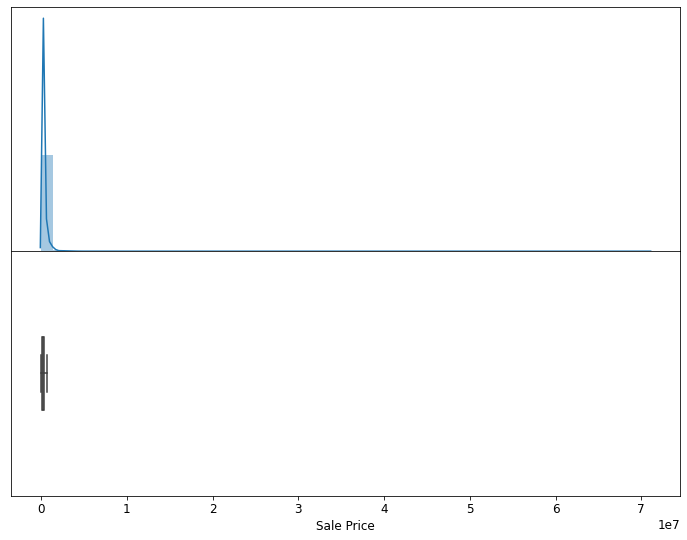

In [12]:
plot_distribution(training_data, label='Sale Price')

<!-- BEGIN QUESTION -->

## Question 2

### Part 1

Identify one issue with the visualization above and briefly describe one way to overcome it. You may also want to try running `training_data['Sale Price'].describe()` in a different cell to see some specific summary statistics on the distribution of the target variable. Make sure to delete the cell afterwards as the autograder may not work otherwise.

<!--
BEGIN QUESTION
name: q2a
points: 1
manual: True
-->

Output of training_data['Sale Price'].describe():

count    2.047920e+05

mean     2.451646e+05

std      3.628694e+05

min      1.000000e+00

25%      4.520000e+04

50%      1.750000e+05

75%      3.120000e+05

max      7.100000e+07

Name: Sale Price, dtype: float64

_From above we know that the majority of property values fall in the range around 10 to the power of 5, however, there are some outliers, for example, the max value is 7.1 times 10 to the power of 7 and the min value is 1. These outliers make the plot look sparse, to fix it, we need to remove these outliers when plotting._

<!-- END QUESTION -->

### Part 2

To zoom in on the visualization of most households, we will focus only on a subset of `Sale Price` for this assignment. In addition, it may be a good idea to apply log transformation to `Sale Price`. In the cell below, reassign `training_data` to a new dataframe that is the same as the original one **except with the following changes**:

- `training_data` should contain only households whose price is at least $500.
- `training_data` should contain a new `Log Sale Price` column that contains the log-transformed sale prices.

**Note**: This also implies from now on, our target variable in the model will be the log transformed sale prices from the column `Log Sale Price`. 

**Note**: You should **NOT** remove the original column `Sale Price` as it will be helpful for later questions.

*To ensure that any error from this part does not propagate to later questions, there will be no hidden test here.*


<!--
BEGIN QUESTION
name: q2b
points: 1
-->

In [13]:
indices = training_data[training_data['Sale Price']<500].index
training_data.drop(indices, inplace=True)
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])
training_data['Log Sale Price'].sum()

2055590.7351105125

In [14]:
grader.check("q2b")

q2b results: All test cases passed!

Let's create a new distribution plot on the log-transformed sale price.

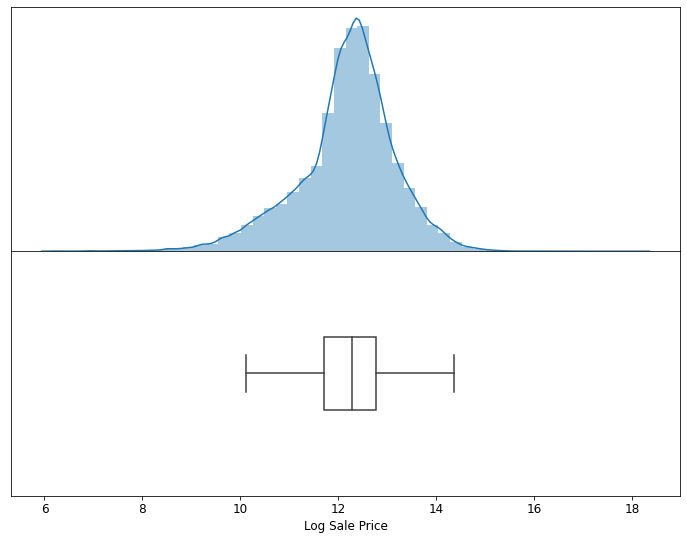

In [15]:
plot_distribution(training_data, label='Log Sale Price');

## Question 3

### Part 1
To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `Log Sale Price` in the training set is left-skewed.
1. The mean of `Log Sale Price` in the training set is greater than the median.
1. At least 25% of the houses in the training set sold for more than \$200,000.00.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to `True` or `False`.*

<!--
BEGIN QUESTION
name: q3a
points:
- 0
- 1
- 1
- 1
-->

In [16]:
# These should be True or False
q3statement1 = True
q3statement2 = False
q3statement3 = True

In [17]:
grader.check("q3a")

q3a results: All test cases passed!

### Part 2

Next, we want to explore if any there is any correlation between `Log Sale Price` and the total area occupied by the household. The `codebook.txt` file tells us the column `Building Square Feet` should do the trick -- it measures "(from the exterior) the total area, in square feet, occupied by the building".

Before creating this jointplot however, let's also apply a log transformation to the `Building Square Feet` column.

In the following cell, create a new column `Log Building Square Feet` in our training data that contains the log transformed area occupied by each household. 

**You should NOT remove the original `Building Square Feet` column this time as it will be used for later questions**. 

*To ensure that any errors from this part do not propagate to later questions, there will be no hidden tests here.*

<!--
BEGIN QUESTION
name: q3b
points: 1
-->

In [18]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

In [19]:
grader.check("q3b")

q3b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Part 3

As shown below, we created a joint plot with `Log Building Square Feet` on the x-axis, and `Log Sale Price` on the y-axis. In addition, we fit a simple linear regression line through the bivariate scatter plot in the middle.

Based on the following plot, does there exist a correlation between `Log Sale Price` and `Log Building Square Feet`? Would `Log Building Square Feet` make a good candidate as one of the features for our model?

![Joint Plot](images/q2p3_jointplot.png)

<!--
BEGIN QUESTION
name: q3c
points: 1
manual: True
-->

_We can see a linear correlation between Log Sale Price and Log Building Square Feet, as Log Building Square Feet increases, Log Sale Price also increases. Log Building Square Feet is a good feature, because the correlation is explainable, since if the area of a property is larger, typically its value is higher too._

<!-- END QUESTION -->

## Question 3

Continuing from the previous part, as you explore the data set, you might still run into more outliers that prevent you from creating a clear visualization or capturing the trend of the majority of the houses. 

For this assignment, we will work to remove these outliers from the data as we run into them. Write a function `remove_outliers` that removes outliers from a data set based off a threshold value of a variable.  For example, `remove_outliers(training_data, 'Building Square Feet', upper=8000)` should return a data frame with only observations that satisfy `Building Square Feet` less than or equal to 8000.

*The provided tests check that training_data was updated correctly, so that future analyses are not corrupted by a mistake. However, the provided tests do not check that you have implemented remove_outliers correctly so that it works with any data, variable, lower, and upper bound.*

<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [20]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    df = data.loc[(data[variable]>upper) & (data[variable]<lower),:]
    return df

In [21]:
grader.check("q4")

q4 results: All test cases passed!

# Part 3: Feature Engineering

In this section we will walk you through a few feature engineering techniques. 

### Bedrooms

Let's start simple by extracting the total number of bedrooms as our first feature for the model. You may notice that the `Bedrooms` column doesn't actually exist in the original dataframe! Instead, it is part of the `Description` column.

## Question 5

### Part 1

Let's take a closer look at the `Description` column first. Compare the description across a few rows together at the same time. For the following list of variables, how many of them can be extracted from the `Description` column? Assign your answer as an integer to the variable `q4a`.
- The date the property was sold on
- The number of stories the property contains
- The previous owner of the property
- The address of the property
- The number of garages the property has
- The total number of rooms inside the property
- The total number of bedrooms inside the property
- The total number of bathrooms inside the property


<!--
BEGIN QUESTION
name: q5a
points:
- 0
- 1
-->

For example, training_data['Description'].iloc[0]

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [22]:
q5a = 6

In [23]:
grader.check("q5a")

q5a results: All test cases passed!

### Part 2

Write a function `add_total_bedrooms(data)` that returns a copy of `data` with an additional column called `Bedrooms` that contains the total number of bathrooms (as integers) for each house. **Treat missing values as zeros if necessary**. Remember that you can make use of vectorized code here; you shouldn't need any `for` statements. 

**Hint**: You should consider inspecting the `Description` column to figure out if there is any general structure within the text. Once you have noticed a certain pattern, you are set with the power of Regex!

<!--
BEGIN QUESTION
name: q5b
points: 2
-->

In [24]:
def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms['Bedrooms'] = with_rooms.apply(lambda row: [s[1] for s in row['Description'].split(",") if "of which are bedrooms" in s][0], axis=1)
    return with_rooms

training_data = add_total_bedrooms(training_data)

In [25]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Part 3

Create a visualization that clearly and succintly shows if there exists an association between  `Bedrooms` and `Log Sale Price`. A good visualization should satisfy the following requirements:
- It should avoid overplotting.
- It should have clearly labeled axes and succinct title.
- It should convey the strength of the correlation between the sale price and the number of rooms. 

**Hint**: A direct scatter plot of the sale price against the number of rooms for all of the households in our training data might risk overplotting.

<!--
BEGIN QUESTION
name: q5c
points: 2
manual: True
format: image
-->

Text(0.5, 1.0, 'Relationship between Bedrooms and Log Sale Price')

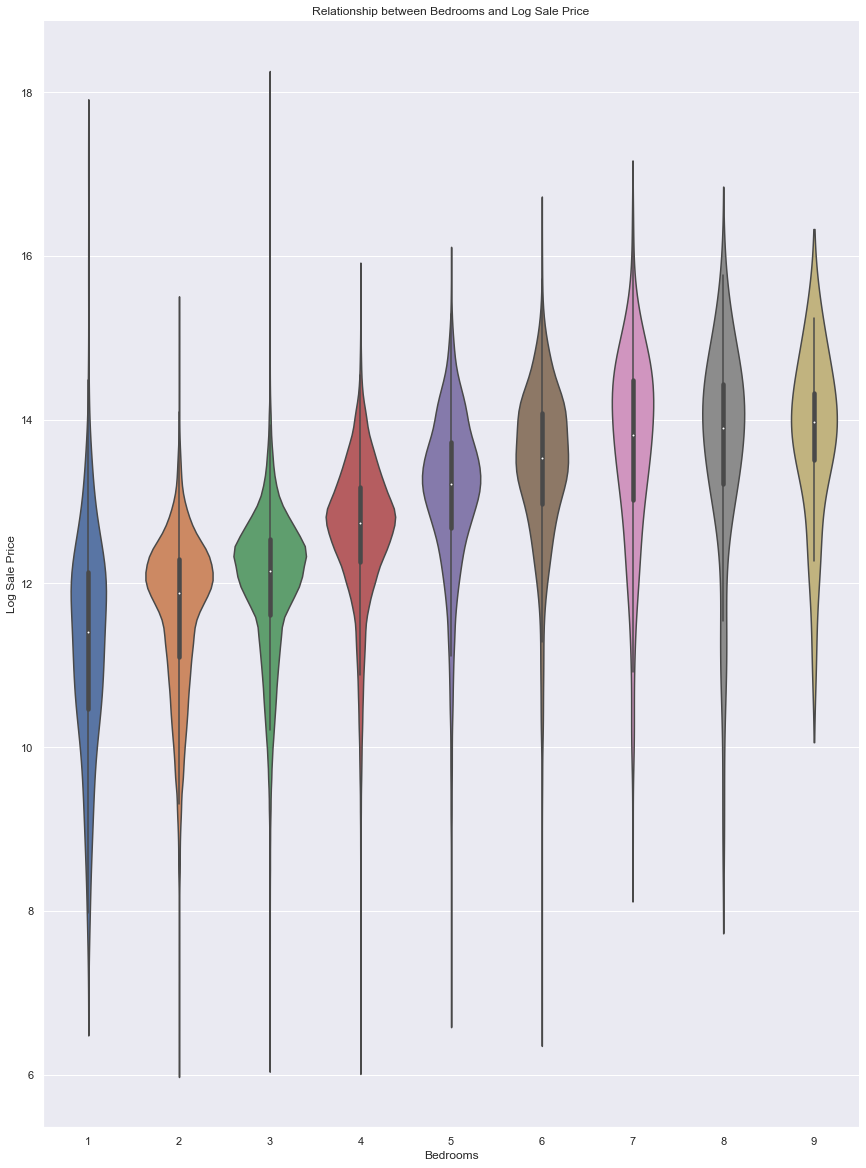

In [26]:
cat_order = sorted(training_data['Bedrooms'].unique())
sns.set(rc={"figure.figsize":(16, 12)})
sns.catplot(x='Bedrooms', y='Log Sale Price', data=training_data, height=16, aspect=.75, order=cat_order, kind='violin')
plt.title("Relationship between Bedrooms and Log Sale Price")

_Explanation: This plot is plotted by seaborn.catplot, which shows the relationship between categorical and continuous data. I use a violin plot, which depicts distributions of numeric data for one or more groups using density curves, to visualize this relationship. We can clearly see from the violin plot that as the number of bedrooms increases, the distribution of Log Sale Price shifts to higher values._

<!-- END QUESTION -->



## Question 6

Now, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set.
Notice that currently we don't have the actual names for the neighborhoods. Instead we will use a similar column `Neighborhood Code` (which is a numerical encoding of the actual neighborhoods by the Assessment office).

### Part 1

Before creating any visualization, let's quickly inspect how many different neighborhoods we are dealing with.

Assign the variable `num_neighborhoods` with the total number of neighborhoods in `training_data`. 

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [27]:
num_neighborhoods = len(training_data['Neighborhood Code'].unique())
num_neighborhoods

193

In [28]:
grader.check("q6a")

q6a results: All test cases passed!

### Part  2

If we try directly plotting the distribution of `Log Sale Price` for all of the households in each neighborhood using the `plot_categorical` function from the next cell, we would get the following visualization.
![overplot](images/q5p2_catplot.png)

In [29]:
def plot_categorical(neighborhoods, data, with_filter=True):
    if not with_filter:
        neighborhoods = data
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods.sort_values('Neighborhood Code'),
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods.sort_values('Neighborhood Code'),
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

Oh no, looks like we have run into the problem of overplotting again! 

You might have noticed that the graph is overplotted because **there are actually quite a few neighborhoods in our dataset**! For the clarity of our visualization, we will have to zoom in again on a few of them. The reason for this is our visualization will become quite cluttered with a super dense x-axis.

Assign the variable `in_top_20_neighborhoods` to a copy of `training_data` that contains only neighborhoods with the top 20 number of buildings. 

<!--
BEGIN QUESTION
name: q6b
points: 2
-->

In [30]:
top_20_data = training_data.copy()
top_20_data['Count'] = 1
top_20_data = top_20_data.groupby('Neighborhood Code', as_index=False).agg("sum")
top_20_data = top_20_data.sort_values('Count', ascending=False)
top_20_neighborhoods = top_20_data['Neighborhood Code'].iloc[0:20].tolist()
in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(top_20_neighborhoods)]
in_top_20_neighborhoods.iloc[[0]]

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3


In [31]:
grader.check("q6b")

q6b results: All test cases passed!

Let's create another of the distribution of sale price within in each neighborhood again, but this time with a narrower focus!

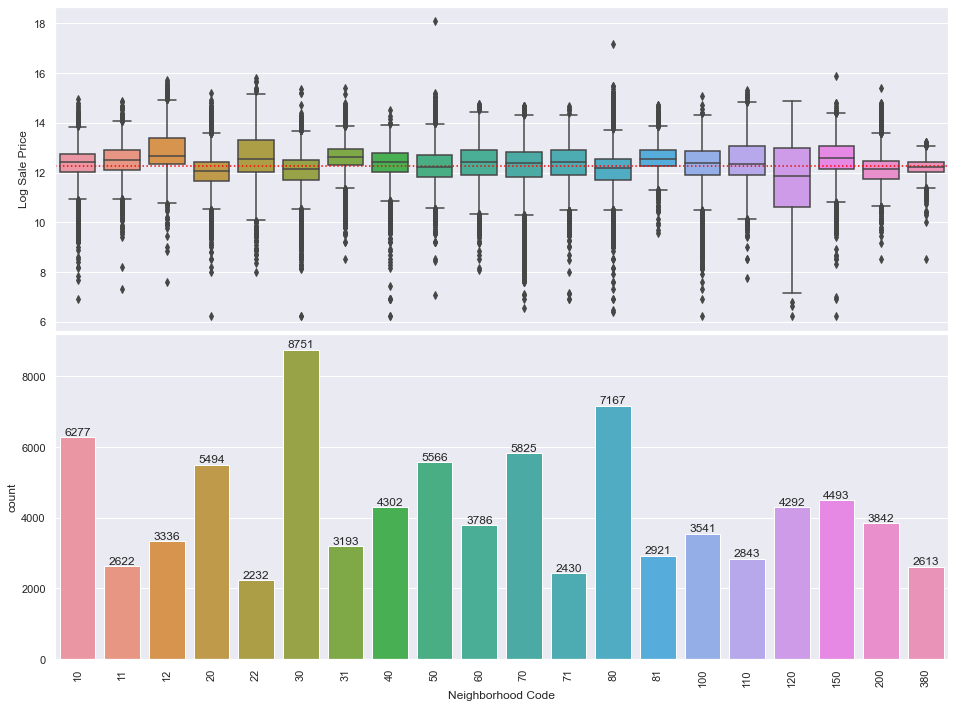

In [32]:
plot_categorical(neighborhoods=in_top_20_neighborhoods, data=training_data)

<!-- BEGIN QUESTION -->

### Part 3

It looks a lot better now than before, right? Based on the plot above, what can be said about the relationship between the houses' `Log Sale Price` and their neighborhoods?

<!--
BEGIN QUESTION
name: q6c
points: 1
manual: True
-->

_Log Sale Price is highly related to neighborhoods, specifically, a neighborhood's houses have a range of sale prices, and a house in that neighborhood is sold within that range (intuitively, some neighborhoods are cheap, while some are expensive). Some neighborhoods have a range with a larger variation (e.g. neighborhood 120 has the largest variation), while other neighborhoods have a range with a smaller variation (e.g. neighborhood 380 has the smallest variation)._

<!-- END QUESTION -->

### Part 4

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `Log Sale Price` and identify them as "expensive neighborhoods"; the other neighborhoods are not marked.

Write a function that returns list of the neighborhood codes of the top `n` most pricy neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_expensive_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `Log Sale Price`.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [33]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric 'Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood Code', as_index=False).aggregate(metric).sort_values(by='Log Sale Price', ascending=False).iloc[:n]['Neighborhood Code'].values.tolist()
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods 

[44, 94, 93]

In [34]:
grader.check("q6d")

q6d results: All test cases passed!

### Part 5
We now have a list of neighborhoods we've deemed as higher-priced than others.  Let's use that information to write a function `add_expensive_neighborhood` that adds a column `in_expensive_neighborhood` which takes on the value 1 if the house is part of `expensive_neighborhoods` and the value 0 otherwise. This type of variable is known as an indicator variable.

**Hint:** [`pd.Series.astype`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Series.astype.html) may be useful for converting True/False values to integers.

<!--
BEGIN QUESTION
name: q6e
points: 1
-->

In [35]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      data frame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(neighborhoods)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

In [36]:
grader.check("q6e")

q6e results: All test cases passed!

## Question 7

In the following question, we will take a closer look at the `Roof Material` feature of the dataset and examine how we can incorporate categorical features into our linear model.

### Part 1

If we look at the codebook carefully, we can see that the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Central Heating (Nominal): 

       1	Shingle/Asphalt
       2	Tar&Gravel
       3	Slate
       4	Shake
       5    Tile
       6    Other
```

Write a function `substitute_roof_material` that replaces each numerical value in `Roof Material` with their corresponding roof material. Your function should return a new DataFrame, not modify the existing DataFrame.

**Hint**: the [DataFrame.replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here.

<!--
BEGIN QUESTION
name: q7a
points: 1
-->


In [37]:
def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    D = {1: 'Shingle/Asphalt',
        2: 'Tar&Gravel',
        3: 'Slate',
        4: 'Shake',
        5: 'Tile',
        6: 'Other'}
    data['Roof Material'] = data['Roof Material'].replace(D)
    return data
    
training_data = substitute_roof_material(training_data)

In [38]:
grader.check("q7a")

q7a results: All test cases passed!

### Part 2

#### An Important Note on One Hot Encoding 

Unfortunately, simply fixing these missing values isn't sufficient for using `Roof Material` in our model.  Since `Roof Material` is a categorical variable, we will have to one-hot-encode the data.  Notice in the example code below that we have to pre-specify the categories.  Why? Imagine what would happen if we automatically generated the categories only from the training data.  What would happen if the testing data contained a category not found in the training set?  For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/user_guide/categorical.html).

Complete the following function `ohe_roof_material` that returns a dataframe with the new column one-hot-encoded on the roof material of the household. These new columns should have the form `x0_MATERIAL`.

**Note**: You should **avoid using `pd.get_dummies`** in your solution as it will remove your original column and is therefore not as reusable as your constructed data preprocessing pipeline. Instead, you can one-hot-encode one column into multiple columns **using Scikit-learn's [One Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)**.

<!--
BEGIN QUESTION
name: q7b
points: 2
-->

In [39]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    one_hot_encoder = OneHotEncoder(sparse=False)
    one_hot_col = one_hot_encoder.fit_transform(data[['Roof Material']])
    data[one_hot_encoder.get_feature_names()] = one_hot_col 
    return data

training_data = ohe_roof_material(training_data)
training_data.filter(regex='^x0').head(10)

,x0_Other,x0_Shake,x0_Shingle/Asphalt,x0_Slate,x0_Tar&Gravel,x0_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


In [40]:
grader.check("q7b")

q7b results: All test cases passed!

## Congratulations! You have finished Homework 8!

In Homework 9, you will use the features you engineered in this homework to build a linear model to predict home prices. In the meantime, consider the implications of your work so far: Given the history of racial discrimination in housing policy and property taxation, defining what a fair assessment entails is no easy feat. In addition to historical context, these assessments are a product of choices made at every level of the assessment process, from data collection to modeling. And the humans who make these choices - real estate agents, data scientists, county assessors, and, in this homework and the next, you - must understand the inputs to and consider the impacts of these decisions.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [41]:
grader.check_all()

q2b results: All test cases passed!

q3a results: All test cases passed!

q3b results: All test cases passed!

q4 results: All test cases passed!

q5a results: All test cases passed!

q5b results: All test cases passed!

q6a results: All test cases passed!

q6b results: All test cases passed!

q6d results: All test cases passed!

q6e results: All test cases passed!

q7a results: All test cases passed!

q7b results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [42]:
# Save your notebook first, then run this cell to export your submission.
grader.export()